In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor, EShapCalcType, EFeaturesSelectionAlgorithm
from statsmodels.tsa.seasonal import STL

import tqdm

2024-11-28 18:07:30.965287: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Baseline model

1. Train set: Use data from 7am - 17pm in train set
2. Test set: To evaluate, only evaluate prediction from 9am - 17pm 
3. Impute missing for all data by linear interpolation, fill forward and backward
4. Scale min max, fit train set
5. Train features to predict their futures by LSTM
6. Train features with response to predict response by Regression

In [21]:
data_dir = os.getcwd()
data = pd.read_csv(data_dir + '/data/add_lag_diff/loc_17.csv')

data_late, data_early, data_to_predict = prepare_dataset(data)

In [82]:
def time_decompose(data_col, period, season):
    stl = STL(data_col.fillna(data_col.interpolate('linear')), period=period, seasonal=season)
    res = stl.fit()
    seasonal_component = res.seasonal
    trend_component = res.trend

    df_deseason = data_col - seasonal_component - trend_component
    df_deseason_imputed = df_deseason.fillna(df_deseason.interpolate('linear'))
    df_imputed = df_deseason_imputed + seasonal_component + trend_component

    return df_imputed, df_deseason, seasonal_component + trend_component

def prepare_dataset(data, features):
    # Mark missing data
    data['date'] = pd.to_datetime(data['DateTime']).dt.date
    data['is_missing'] = data['Power(mW)'].isnull()
    data['gap_group'] = (~data['is_missing']).cumsum()
    gap_counts = (
        data.groupby('gap_group')['is_missing']
        .sum()
        .reset_index(name='missing_count')
    )
    gap_counts = gap_counts[gap_counts['missing_count'] > 0]

    # Drop the date that have large gap
    # group_lst = gap_counts[gap_counts['missing_count'] > 60]['gap_group'].values
    # missing_date_lst = data[data['gap_group'].isin(group_lst)]['date'].unique()
    # data = data[~data['date'].isin(missing_date_lst)]

    # Impute use decomposition
    for feat in features:
        data[feat], data[f'{feat}_deseason'], data[f'{feat}_season_trend'] = time_decompose(data[feat], 60*30, 15)

    # # Get the complete day only
    # data['date'] = pd.to_datetime(data['DateTime']).dt.date
    # record_counts = data.groupby('date').size()
    # data = data[data['date'].isin(list(record_counts[record_counts == 60].index))]
    data['power_lag1'] = feature_differencing(data['Power(mW)_log'], 1)
    # train_set['power_lag60'] = feature_differencing(train_set['Power(mW)'], 60)
    data['power_lag2'] = feature_differencing(data['Power(mW)_log'], 2)
    data['power_lag3'] = feature_differencing(data['Power(mW)_log'], 3)
    data['power_lag4'] = feature_differencing(data['Power(mW)_log'], 4)
    data['power_lag5'] = feature_differencing(data['Power(mW)_log'], 5)

    # get train data and input for test
    hour_dt = pd.to_datetime(data["DateTime"]).dt.time
    data_late = data[(hour_dt >= pd.to_datetime("07:00").time()) & 
                        (hour_dt < pd.to_datetime("17:00").time())]
    
    data_early = data[(hour_dt >= pd.to_datetime("07:00").time()) & 
                        (hour_dt < pd.to_datetime("09:00").time())]
    
    data_to_predict = data_late[data_late['to_predict'] == 1]
    # data_to_predict = data_late
    print(data_to_predict.shape)
    # data_to_predict = data_late

    # drop date with missing value 
    record_counts = data_late.groupby('date')['is_missing'].sum()
    data_late = data_late[data_late['date'].isin(list(record_counts[record_counts == 0].index))]

    record_counts = data_early.groupby('date')['is_missing'].sum()
    data_early = data_early[data_early['date'].isin(list(record_counts[record_counts == 0].index))]
    
    return data_late, data_early, data_to_predict

def impute_missing(data):
    """
    data: DataFrame
    """
    features = data.columns
    for feature in features:
        data[feature] = data[feature].interpolate(method='nearest', limit_direction='both')
        data[feature] = data[feature].ffill()
        data[feature] = data[feature].bfill()

    return data


def scale_min_max(fit_data):
    """
    train_set, test_set: numpy array
    """
    minmax_scaler = MinMaxScaler().fit(fit_data)
    data_scaled = minmax_scaler.transform(fit_data)

    return data_scaled, minmax_scaler


def feature_differencing(time_feature, lag):
    diff_feat = time_feature[:-lag]
    diff_feat = np.append(diff_feat.values[:lag], diff_feat)
    return diff_feat
    
    
def add_features(data, time_col):
    data['hour'] = pd.to_datetime(data[time_col]).dt.hour
    data['minute'] = pd.to_datetime(data[time_col]).dt.minute
    
    return data
    
    
def window_data(data, look_back_num):
    """
    data: numpy array
    """
    X_train = []
    y_train = []

    # # input X, each look_back_num points is corresponding to 1 y (y dim is 5)
    for i in range(look_back_num, data.shape[0]):
        X_train.append(data[i-look_back_num:i, :])
        y_train.append(data[i, :])

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], data.shape[1]))  # num obs * time sequence length * num features

    return X_train, y_train


# Modelling

def lstm_model(X_train, y_train, epochs, batch_size):
    regressor = Sequential()
    regressor.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))  # each input is time sequence length * num features
    regressor.add(LSTM(units = 64))
    regressor.add(Dropout(0.2))

    # output layer
    regressor.add(Dense(units=y_train.shape[1]))
    regressor.compile(optimizer='adam', loss='mean_squared_error')
    # regressor.summary()
    history = regressor.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, verbose=True)

    return regressor, history

def train_model(train_set, look_back_num, epochs, batch_size):
    ## LSTM
    train_set = add_features(train_set, 'DateTime')
    # train_set['power_lag1'] = feature_differencing(train_set['Power(mW)_log'], 1)
    # # train_set['power_lag60'] = feature_differencing(train_set['Power(mW)'], 60)
    # train_set['power_lag2'] = feature_differencing(train_set['Power(mW)_log'], 2)
    # train_set['power_lag3'] = feature_differencing(train_set['Power(mW)_log'], 3)
    # train_set['power_lag4'] = feature_differencing(train_set['Power(mW)_log'], 4)
    # train_set['power_lag5'] = feature_differencing(train_set['Power(mW)_log'], 5)

    features = ['hour', 'minute', 'WindSpeed(m/s)', 'Pressure(hpa)',
                'Temperature(°C)',
                'Humidity(%)','Sunlight(Lux)', 
                'power_lag1', 
                'power_lag2', 'power_lag3', 'power_lag4', 'power_lag5',
                'Power(mW)_log']
    # features = ['Pressure(hpa)','Temperature(°C)','Humidity(%)','Sunlight(Lux)', 'Power(mW)']
    X_features = features[:-1]
    
    # get log
#     train_set[features[1:]] = np.log(train_set[features[1:]] + 1)
    
    train_imputed = impute_missing(train_set[features])
    # train_imputed = train_set.dropna()
    # print(np.sum(np.isnan(train_imputed)))
    # train_imputed = train_set[features].dropna()
    train_scaled, minmax_scaler = scale_min_max(train_imputed[X_features])
    # X_train, X_train_later = window_data(train_scaled, look_back_num)
    # regressor, history = lstm_model(X_train, X_train_later, epochs, batch_size)

    ## CatBoost

    y_train = train_imputed[['Power(mW)_log']]
    y_train_scaled, y_scaler = scale_min_max(y_train)
    cat_params = dict(iterations=7000,
                      learning_rate=0.01,
                      depth=11,
                      l2_leaf_reg=30,
                      bootstrap_type='Bernoulli',
                      subsample=0.66,
                      loss_function='MAE',
                      eval_metric = 'MAE',
                      metric_period=100,
                      od_type='Iter',
                      od_wait=30,
                      task_type='GPU',
                      allow_writing_files=False,
                      )

    # Train a LightGBM model for the current fold
    cat_model = CatBoostRegressor(**cat_params)
    cat_model.fit(
        train_scaled,
        y_train_scaled,
        early_stopping_rounds=100
    )
    
    return minmax_scaler, cat_model, y_scaler

In [83]:
def lstm_predict(model, forecast_num, look_back_num, input_data, to_predict):
    # Only apply for look_back_num = 12 and forecast_num = 48
    predictions = []
    # print(input_data.shape[0]/12)
    # print(to_predict.shape[0]/48)
    i = look_back_num
    while i < input_data.shape[0] + 1:
        # print(i)
        input_df = input_data[(i-look_back_num):i, :]
        input_seq = np.array(input_df).reshape(1, input_df.shape[0], input_df.shape[1])
        # print(input_seq)
        for _ in range(forecast_num):
            next_pred = model.predict(input_seq, verbose=False)
            predictions.append(next_pred[0])
            # print(predictions)
            input_seq = np.append(input_seq[:, 1:, :], [[next_pred[0]]], axis=1)

        print(len(predictions))
        i = i + look_back_num
        
    return np.array(predictions)


def predict_power(test_set, to_predict_data, forecast_num, look_back_num, cat_model, minmax_scaler):
    # date_lst = to_predict_data['date'].unique()
    test_set = add_features(test_set, 'DateTime')
    # test_set['power_lag1'] = feature_differencing(test_set['Power(mW)_log'], 1)
    # test_set['power_lag2'] = feature_differencing(test_set['Power(mW)_log'], 2)
    # test_set['power_lag3'] = feature_differencing(test_set['Power(mW)_log'], 3)
    # test_set['power_lag4'] = feature_differencing(test_set['Power(mW)_log'], 4)
    # test_set['power_lag5'] = feature_differencing(test_set['Power(mW)_log'], 5)
    # test_set['power_lag60'] = feature_differencing(test_set['Power(mW)'], 60)
    # test_set['is_missing'] = np.where(test_set['Power(mW)'].isna(), 1, 0)
    # test_set = test_set[test_set['date'].isin(date_lst)]

    # test_set['WindSpeed(m/s)'] = test_set['WindSpeed(m/s)'].fillna(test_set['WindSpeed(m/s)_imputed'])
    # test_set['Pressure(hpa)'] = test_set['Pressure(hpa)'].fillna(test_set['Pressure(hpa)_imputed'])
    # test_set['Temperature(°C)'] = test_set['Temperature(°C)'].fillna(test_set['Temperature(°C)_imputed'])
    # test_set['Humidity(%)'] = test_set['Humidity(%)'].fillna(test_set['Humidity(%)_imputed'])
    # test_set['Sunlight(Lux)'] = test_set['Sunlight(Lux)'].fillna(test_set['Sunlight(Lux)_imputed'])

    features = ['hour', 'minute', 'WindSpeed(m/s)', 'Pressure(hpa)',
                'Temperature(°C)',
                'Humidity(%)','Sunlight(Lux)', 
                'power_lag1', 
                'power_lag2', 'power_lag3', 'power_lag4', 'power_lag5', 
                'Power(mW)_log']
    # features = ['Pressure(hpa)','Temperature(°C)','Humidity(%)','Sunlight(Lux)', 'Power(mW)']
    X_features = features[:-1]
    
    # get log
#     test_set[features[1:]] = np.log(test_set[features[1:]] + 1)
    
    test_imputed = impute_missing(test_set[features])
    test_scaled = minmax_scaler.transform(test_imputed[X_features])
    # X_test_pred = lstm_predict(lstm_regressor, forecast_num, look_back_num, test_scaled, to_predict_data)
    X_test_pred = test_scaled

    y_pred = cat_model.predict(X_test_pred).reshape(to_predict_data.shape[0])
    # y_pred = np.exp(y_pred) - 1
#     y_test = np.exp(y_test) - 1

    return X_test_pred, y_pred


In [99]:
features = ['WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)', 'Power(mW)_log']
location_lst = range(1, 18, 1)
look_back_num = 12
forecast_num = 48
data_dir = os.getcwd()

all_predictions = pd.DataFrame(columns = ["serial", "y_pred"])
for loc in location_lst:
    print(loc, "----------------------------------------------------------------------------------------------------")
    data = pd.read_csv(data_dir + f'/data/add_lag_diff/loc_{loc}.csv')
    data_late, data_early, data_to_predict = prepare_dataset(data, features)

    # data_late_train, data_late_test = data_late.reset_index().loc[:5500, ], data_late.reset_index().loc[5500:, ]
    minmax_scaler, cat_model, y_scaler = train_model(data_late, look_back_num=look_back_num, epochs=500, batch_size=128)
    X_test_pred, y_pred = predict_power(data_to_predict, data_to_predict,  
                                         forecast_num=forecast_num, look_back_num=look_back_num,
                                         cat_model=cat_model, minmax_scaler=minmax_scaler)
    y_pred_norm = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)
    y_pred_norm = np.exp(y_pred_norm) - 1

    df = pd.DataFrame(columns = ["serial", "y_pred"])
    df['serial'] = data_to_predict['Serial']
    # df['y_pred'] = (y_pred_norm + data_to_predict['Power(mW)_log_season_comp']).values
    df['y_pred'] = y_pred_norm

    all_predictions = pd.concat([all_predictions, df])

1 ----------------------------------------------------------------------------------------------------
(1152, 96)
0:	learn: 0.2185962	total: 22.2ms	remaining: 2m 35s
100:	learn: 0.0244939	total: 1.74s	remaining: 1m 58s
200:	learn: 0.0162684	total: 4.22s	remaining: 2m 22s
300:	learn: 0.0145101	total: 6.43s	remaining: 2m 23s
400:	learn: 0.0129145	total: 9.23s	remaining: 2m 31s
500:	learn: 0.0115648	total: 12.1s	remaining: 2m 36s
600:	learn: 0.0107079	total: 14.5s	remaining: 2m 34s
700:	learn: 0.0099039	total: 17.3s	remaining: 2m 35s
800:	learn: 0.0091649	total: 20.1s	remaining: 2m 35s
900:	learn: 0.0085059	total: 23.1s	remaining: 2m 36s
1000:	learn: 0.0078810	total: 26.8s	remaining: 2m 40s
1100:	learn: 0.0073794	total: 31.2s	remaining: 2m 47s
1200:	learn: 0.0068589	total: 36.1s	remaining: 2m 54s
1300:	learn: 0.0063931	total: 41s	remaining: 2m 59s
1400:	learn: 0.0059735	total: 45.9s	remaining: 3m 3s
1500:	learn: 0.0056397	total: 50.7s	remaining: 3m 5s
1600:	learn: 0.0052867	total: 57s	rem

KeyboardInterrupt: 

In [100]:
output = pd.read_csv("upload(no answer).csv")

In [101]:
output = output.merge(all_predictions, left_on='序號', right_on='serial', how='left')

In [108]:
output

,序號,答案,serial,y_pred
0,20240117090001,NaN,20240117090001,119.455053
1,20240117091001,NaN,20240117091001,155.125071
2,20240117092001,NaN,20240117092001,159.664296
3,20240117093001,NaN,20240117093001,155.341141
4,20240117094001,NaN,20240117094001,168.849193
...,...,...,...,...
9595,20241002161012,NaN,NaN,NaN
9596,20241002162012,NaN,NaN,NaN
9597,20241002163012,NaN,NaN,NaN
9598,20241002164012,NaN,NaN,NaN


In [110]:
output['y_pred'] = output['y_pred'].fillna(output_stl['答案'])

In [105]:
output_stl = pd.read_csv("output_stl_1f.csv")
output_stl.describe()

,序號,答案
count,9.600000e+03,9600.000000
mean,2.024053e+13,192.611740
std,2.204042e+08,384.357806
min,2.024011e+13,-0.858659
25%,2.024033e+13,10.539154
50%,2.024052e+13,39.321758
75%,2.024070e+13,193.342130
max,2.024103e+13,4432.049374


In [111]:
output['答案'] = output['y_pred']
output[['序號', '答案']].to_csv('output_stl_season.csv', index=False)

In [63]:
X_test_pred_norm = minmax_scaler.inverse_transform(X_test_pred)
# y_pred_norm = y_scaler.inverse_transform(y_pred.reshape(-1, 1))

In [61]:
df.describe()

,serial,y_pred
count,1.152000e+03,1152.000000
mean,2.024044e+13,57.944188
std,2.087225e+08,36.741930
min,2.024011e+13,-0.259557
25%,2.024023e+13,30.719916
50%,2.024051e+13,53.550269
75%,2.024062e+13,80.607256
max,2.024072e+13,190.295157


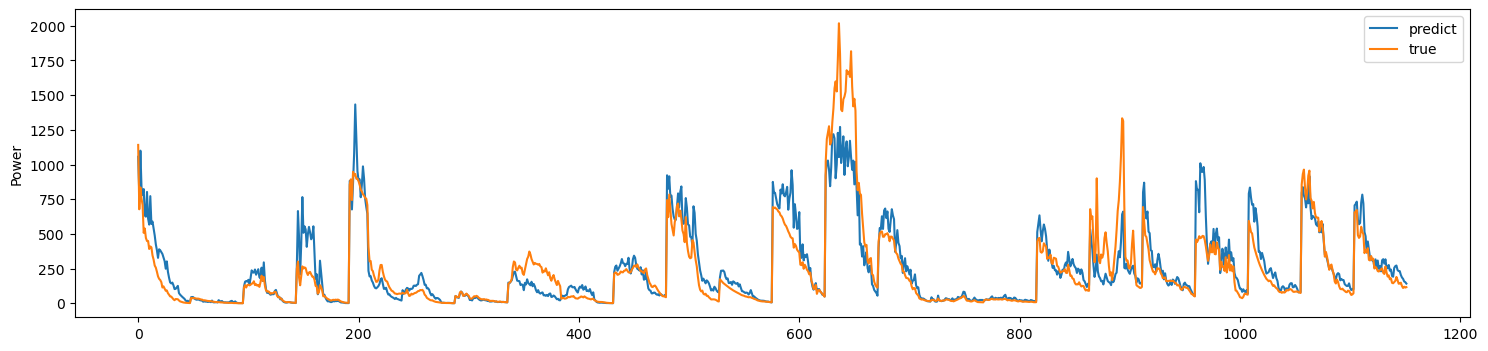

In [98]:
y_test = (np.exp(data_to_predict['Power(mW)_log']) - 1).values
y_pred = y_pred_norm
# y_test = data_to_predict['Power(mW)_log_deseason'].values
# y_pred = y_pred_norm
# y_pred_season = (y_pred_norm.reshape(-1) + data_to_predict['Power(mW)_season_comp']).values

plt.figure(figsize=(18, 28))

plt.subplot(6, 1, 1)
plt.plot(y_pred, label='predict')
plt.plot(y_test, label='true')
plt.ylabel('Power')
plt.legend()

# plt.subplot(6, 1, 2)
# plt.plot(X_test_pred_norm[:, 2], label='predict')
# plt.plot(data_to_predict['WindSpeed(m/s)_imputed'].values, label='true')
# plt.ylabel('Wind')
# plt.legend()

# plt.subplot(6, 1, 3)
# plt.plot(X_test_pred_norm[:, 3], label='predict')
# plt.plot(data_to_predict['Pressure(hpa)_imputed'].values, label='true')
# plt.ylabel('Pressure')
# plt.legend()

# plt.subplot(6, 1, 4)
# plt.plot(X_test_pred_norm[:, 4], label='predict')
# plt.plot(data_to_predict['Temperature(°C)_imputed'].values, label='true')
# plt.ylabel('Temp')
# plt.legend()

# plt.subplot(6, 1, 5)
# plt.plot(X_test_pred_norm[:, 5], label='predict')
# plt.plot(data_to_predict['Humidity(%)_imputed'].values, label='true')
# plt.ylabel('Humid')
# plt.legend()

# plt.subplot(6, 1, 6)
# plt.plot(X_test_pred_norm[:, 6], label='predict')
# plt.plot(data_to_predict['Sunlight(Lux)_imputed'].values, label='true')
# plt.ylabel('Sun')
# plt.legend()


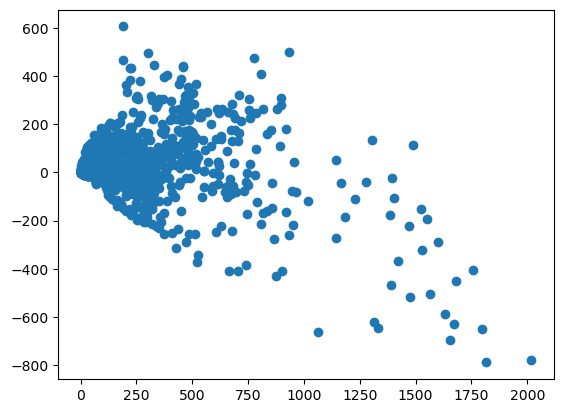

In [96]:
plt.scatter(y_test, y_pred - y_test)  

In [27]:
df

,datetime,location,y_test,y_pred,serial
12,2024-01-01 09:00:00,1,17.368000,25.128813,20240101090001
13,2024-01-01 09:10:00,1,12.612000,63.925981,20240101091001
14,2024-01-01 09:20:00,1,8.807000,115.718400,20240101092001
15,2024-01-01 09:30:00,1,17.564000,180.684807,20240101093001
16,2024-01-01 09:40:00,1,7.508000,204.284762,20240101094001
...,...,...,...,...,...
12355,2024-07-24 16:10:00,1,0.146000,16.648295,20240724161001
12356,2024-07-24 16:20:00,1,0.106000,16.354769,20240724162001
12357,2024-07-24 16:30:00,1,0.054000,16.471685,20240724163001
12358,2024-07-24 16:40:00,1,0.025556,16.537115,20240724164001


In [18]:
mae = np.mean(np.abs(all_predictions['y_test'] - all_predictions['y_pred']))
mae

455.64363979339225

In [19]:
no_missing = all_predictions[all_predictions['is_missing'] == 0]
mae = np.mean(np.abs(no_missing['y_test'] - no_missing['y_pred']))
mae

470.19489577111347

In [15]:
## Retrain 3 because it looks weird

loc=3
minmax_scaler, regressor, history, lin_reg = train_model(loc, look_back_num=look_back_num, epochs=300, batch_size=512)
X_test_true, X_test_pred, y_pred, y_test, date_miss = predict_power(loc, look_back_num=look_back_num, 
                                                         forecast_num=forecast_num, lstm_regressor=regressor, 
                                                         lin_reg=lin_reg, minmax_scaler=minmax_scaler)
df = pd.DataFrame(columns = ["datetime", "location", "y_test", "y_pred", "is_missing"])
df["datetime"] = date_miss['DateTime']
df["is_missing"] = date_miss['is_missing']
df["location"] = loc
df["y_test"] = y_test
df["y_pred"] = y_pred
print("MAE of location {i}: ".format(i=loc), np.mean(np.abs(df['y_test'] - df['y_pred'])))

MAE of location 3:  1590.1381620925763


In [17]:
# all_predictions = all_predictions.reset_index(drop=True)
all_predictions.loc[all_predictions['location'] == 3, :] = df

In [144]:
all_predictions.loc[11767:12858, 'location'] = 12

In [149]:
no_missing = all_predictions[all_predictions['is_missing'] == 0]
mae = np.mean(np.abs(no_missing['y_test'] - no_missing['y_pred']))
mae

432.3412562823701

In [150]:
all_predictions.to_csv("output/output_lag1.csv", index=False)

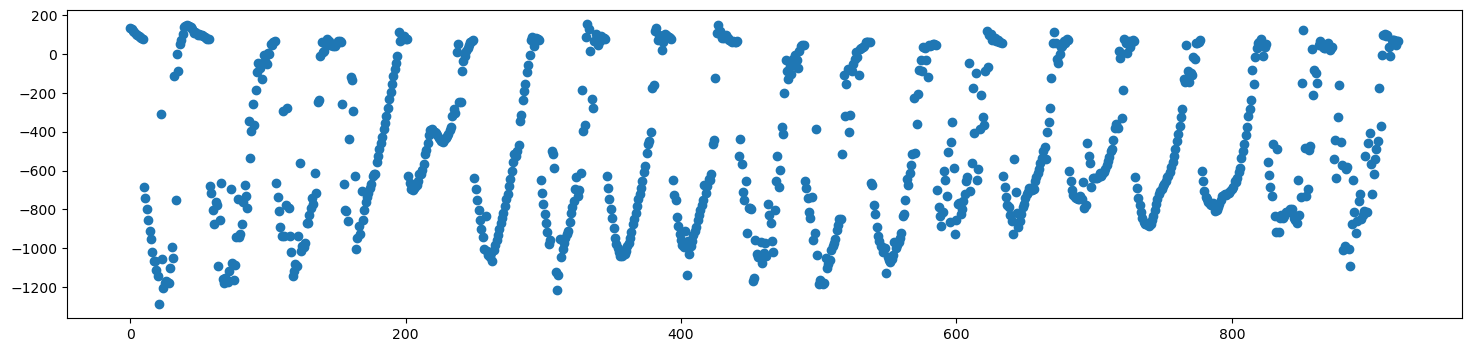

In [21]:
plt.figure(figsize=(18, 28))
y_ax = no_missing.loc[no_missing['location'] == 2, 'y_pred'] - no_missing.loc[no_missing['location'] == 2, 'y_test'] 

plt.subplot(6, 1, 1)
# plt.plot(np.arange(2000), np.arange(2000))
plt.scatter(np.arange(len(y_ax)), y_ax)

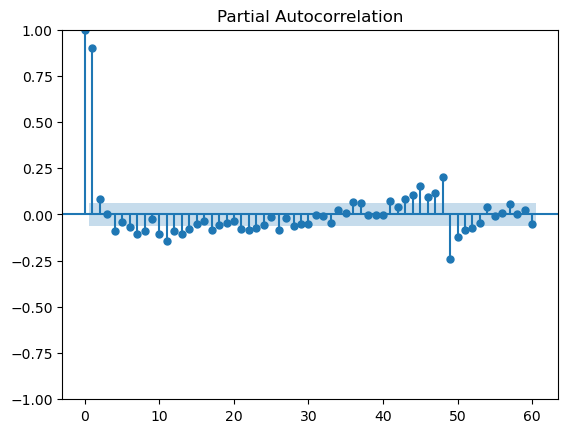

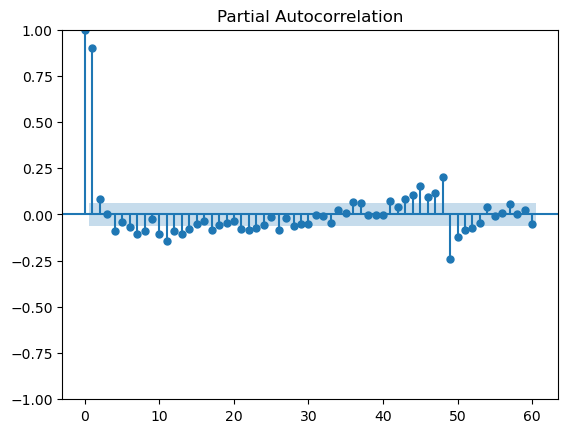

In [ ]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# plot_pacf(y_ax, lags=60)

In [101]:
no_missing.loc[no_missing['location'] == 5, 'y_test'].shape

(576,)

# Baseline (without windspeed)

In [7]:
location_lst = range(1, 18, 1)
look_back_num = 12
forecast_num = 48

all_predictions = pd.DataFrame(columns = ["datetime", "location", "y_test", "y_pred"])
for loc in location_lst:
    print(loc)
    minmax_scaler, regressor, history, lin_reg = train_model(loc, look_back_num=look_back_num, epochs=500, batch_size=512)
    X_test_true, X_test_pred, y_pred, y_test, date_miss = predict_power(loc, look_back_num=look_back_num, 
                                                             forecast_num=forecast_num, lstm_regressor=regressor, 
                                                             lin_reg=lin_reg, minmax_scaler=minmax_scaler)
    df = pd.DataFrame(columns = ["datetime", "location", "y_test", "y_pred", "is_missing"])
    df["datetime"] = date_miss['DateTime']
    df["is_missing"] = date_miss['is_missing']
    df["location"] = loc
    df["y_test"] = y_test
    df["y_pred"] = y_pred
    print("MAE of location {i}: ".format(i=loc), np.mean(np.abs(df['y_test'] - df['y_pred'])))

    all_predictions = pd.concat([all_predictions, df])

1
MAE of location 1:  2565.461643806146
2
MAE of location 2:  362.86356925642275
3
MAE of location 3:  1441.455912933955
4
MAE of location 4:  659.2662560568165
5
MAE of location 5:  748.7796853483253
6
MAE of location 6:  562.2626608133307
7
MAE of location 7:  966.483484117751
8
MAE of location 8:  161.8023780989333
9
MAE of location 9:  230.6848413639127
10
MAE of location 10:  1092.0922996320612
11
MAE of location 11:  15.014703090918925
12
MAE of location 12:  510.9939710950664
13
MAE of location 13:  531.0760744192472
14
MAE of location 14:  425.99017836995523
15
MAE of location 15:  553.1719322121623
16
MAE of location 16:  588.081290298157
17
MAE of location 17:  473.2310054823779


In [8]:
no_missing = all_predictions[all_predictions['is_missing'] == 0]
mae = np.mean(np.abs(no_missing['y_test'] - no_missing['y_pred']))
mae

764.8591096328307

In [9]:
all_predictions.to_csv("output/output_baseline_no_wind.csv", index=False)

In [11]:
train_file = os.path.join(os.getcwd(), "avg_data_10min_wh/loc_{i}/fold_4/train.csv".format(i=1))
train_set = pd.read_csv(train_file, encoding='utf-8')
train_set.head()

,DateTime,LocationCode,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW)
0,2024-01-01 07:00:00,1.0,0.00000,1016.730,17.50,86.99,470.834,0.083
1,2024-01-01 07:10:00,1.0,0.00000,1016.774,17.57,86.97,659.667,0.139
2,2024-01-01 07:20:00,1.0,0.68193,1016.922,17.63,86.18,889.666,0.247
3,2024-01-01 07:30:00,1.0,0.60737,1016.992,17.74,85.41,1263.833,0.447
4,2024-01-01 07:40:00,1.0,0.00000,1017.094,17.90,85.41,2136.833,1.129


In [13]:
train_set['DateTime']

0        2024-01-01 07:00:00
1        2024-01-01 07:10:00
2        2024-01-01 07:20:00
3        2024-01-01 07:30:00
4        2024-01-01 07:40:00
                ...         
10315    2024-06-20 16:10:00
10316    2024-06-20 16:20:00
10317    2024-06-20 16:30:00
10318    2024-06-20 16:40:00
10319    2024-06-20 16:50:00
Name: DateTime, Length: 10320, dtype: object